# NLP Exploration

In [17]:
import pandas as pd
from goose3 import Goose
from goose3.configuration import Configuration

import spacy
from spacy import displacy

import geopy 
import matplotlib.pyplot as plt
from geopy.extra.rate_limiter import RateLimiter
import folium
from folium.plugins import FastMarkerCluster
from wordcloud import WordCloud    
import numpy as np
from PIL import Image

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import random
import torch
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from datasets import load_dataset
import seaborn as sns

import geonamescache
import time

## Question answering

In [2]:
#torch.cuda.empty_cache()

In [3]:
# Use a GPU if you have one available (Runtime -> Change runtime type -> GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set seeds for reproducibility
random.seed(26)
np.random.seed(26)
torch.manual_seed(26)

tokenizer = AutoTokenizer.from_pretrained("roberta-base") 

model = AutoModelForSequenceClassification.from_pretrained("roberta-base")
model.to(device) # Send the model to the GPU if we have one

learning_rate = 1e-5
optimizer = AdamW(model.parameters(), lr=learning_rate, eps=1e-4)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

In [4]:
boolq_t = load_dataset('boolq', split='train')
boolq_v = load_dataset('boolq', split='validation')

Using custom data configuration default
Reusing dataset boolq (C:\Users\walle\.cache\huggingface\datasets\boolq\default\0.1.0\bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5)
Using custom data configuration default
Reusing dataset boolq (C:\Users\walle\.cache\huggingface\datasets\boolq\default\0.1.0\bf0dd57da941c50de94ae3ce3cef7fea48c08f337a4b7aac484e9dddc5aa24e5)


In [5]:
print('Len train :', len(boolq_t))
print('Len val :', len(boolq_v))

Len train : 9427
Len val : 3270


In [6]:
def encode_data(tokenizer, questions, passages, max_length):
    """Encode the question/passage pairs into features than can be fed to the model."""
    input_ids = []
    attention_masks = []

    for question, passage in zip(questions, passages):
        encoded_data = tokenizer.encode_plus(question, passage, max_length=max_length, pad_to_max_length=True, truncation_strategy="longest_first")
        encoded_pair = encoded_data["input_ids"]
        attention_mask = encoded_data["attention_mask"]

        input_ids.append(encoded_pair)
        attention_masks.append(attention_mask)

    return np.array(input_ids), np.array(attention_masks)

# Loading data
train_data_df = boolq_t[:1500]
dev_data_df = boolq_v[:500]

passages_train = train_data_df['passage']
questions_train = train_data_df['question']
answers_train = [int(x) for x in train_data_df['answer']]

passages_dev = dev_data_df['passage']
questions_dev = dev_data_df['question']
answers_dev = [int(x) for x in dev_data_df['answer']]


# Encoding data
max_seq_length = 256
input_ids_train, attention_masks_train = encode_data(tokenizer, questions_train, passages_train, max_seq_length)
input_ids_dev, attention_masks_dev = encode_data(tokenizer, questions_dev, passages_dev, max_seq_length)

train_features = (input_ids_train, attention_masks_train, answers_train)
dev_features = (input_ids_dev, attention_masks_dev, answers_dev)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\walle\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2212: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
batch_size = 8

train_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in train_features]
dev_features_tensors = [torch.tensor(feature, dtype=torch.long) for feature in dev_features]

train_dataset = TensorDataset(*train_features_tensors)
dev_dataset = TensorDataset(*dev_features_tensors)

train_sampler = RandomSampler(train_dataset)
dev_sampler = SequentialSampler(dev_dataset)

train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler=dev_sampler, batch_size=batch_size)

In [8]:
epochs = 15
grad_acc_steps = 1
train_loss_values = []
dev_acc_values = []

for _ in tqdm(range(epochs), desc="Epoch"):

    # Training
    epoch_train_loss = 0 # Cumulative loss
    model.train()
    model.zero_grad()

    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)     

        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks, labels=labels)

        loss = outputs[0]
        loss = loss / grad_acc_steps
        epoch_train_loss += loss.item()

        loss.backward()

        if (step+1) % grad_acc_steps == 0: # Gradient accumulation is over
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Clipping gradients
            optimizer.step()
            model.zero_grad()

    epoch_train_loss = epoch_train_loss / len(train_dataloader)          
    train_loss_values.append(epoch_train_loss)

    # Evaluation
    epoch_dev_accuracy = 0 # Cumulative accuracy
    model.eval()

    for batch in dev_dataloader:

        input_ids = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2]

        with torch.no_grad():        
            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_masks)

        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
    

        predictions = np.argmax(logits, axis=1).flatten()
        labels = labels.numpy().flatten()

        epoch_dev_accuracy += np.sum(predictions == labels) / len(labels)

    epoch_dev_accuracy = epoch_dev_accuracy / len(dev_dataloader)
    dev_acc_values.append(epoch_dev_accuracy)

Epoch: 100%|██████████| 15/15 [10:31<00:00, 42.11s/it]


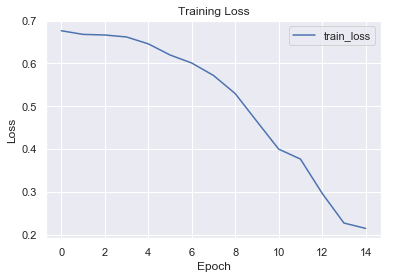

In [14]:
sns.set()

plt.plot(train_loss_values, label="train_loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
#plt.xticks(np.arange(0, 5))
plt.show()

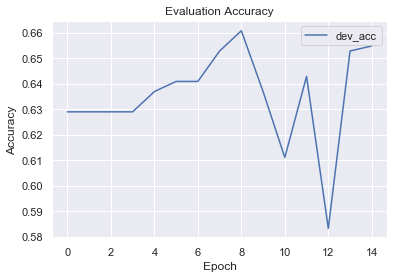

In [15]:
plt.plot(dev_acc_values, label="dev_acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy")
plt.legend()
plt.show()

In [16]:
def predict(question, passage):
    sequence = tokenizer.encode_plus(question, passage, return_tensors="pt")['input_ids'].to(device)

    logits = model(sequence)[0]
    probabilities = torch.softmax(logits, dim=1).detach().cpu().tolist()[0]
    proba_yes = round(probabilities[1], 2)
    proba_no = round(probabilities[0], 2)

    print(f"Question: {question}, Yes: {proba_yes}, No: {proba_no}")

passage_superbowl = """Super Bowl 50 was an American football game to determine the champion of the National Football League
                    (NFL) for the 2015 season. The American Football Conference (AFC) champion Denver Broncos defeated
                    the National Football Conference (NFC) champion Carolina Panthers 24–10 to earn their third Super Bowl title.
                    The game was played on February 7, 2016, at Levi's Stadium in the San Francisco Bay Area at Santa Clara,
                    California. As this was the 50th Super Bowl, the league emphasized the 'golden anniversary' with various
                    gold-themed initiatives, as well as temporarily suspending the tradition of naming each Super Bowl game
                    with Roman numerals (under which the game would have been known as 'Super Bowl L'), so that the logo could
                    prominently feature the Arabic numerals 50."""
 
passage_illuin = """Illuin designs and builds solutions tailored to your strategic needs using Artificial Intelligence
                  and the new means of human interaction this technology enables."""

passage_illuin = "Illuin is the new mean of human interaction this technology enables."

superbowl_questions = [
"Did the Denver Broncos win the Super Bowl 50?", 
"Did the Carolina Panthers win the Super Bowl 50?",
"Was the Super Bowl played at Levi's Stadium?", 
"Was the Super Bowl 50 played in Las Vegas?", 
"Was the Super Bowl 50 played in February?", 
"Was the Super Bowl 50 played in March?"
]

question_illuin = "Is Illuin the answer to your strategic needs?"

for s_question in superbowl_questions:
    predict(s_question, passage_superbowl)

predict(question_illuin, passage_illuin)

Question: Did the Denver Broncos win the Super Bowl 50?, Yes: 1.0, No: 0.0
Question: Did the Carolina Panthers win the Super Bowl 50?, Yes: 1.0, No: 0.0
Question: Was the Super Bowl played at Levi's Stadium?, Yes: 1.0, No: 0.0
Question: Was the Super Bowl 50 played in Las Vegas?, Yes: 1.0, No: 0.0
Question: Was the Super Bowl 50 played in February?, Yes: 1.0, No: 0.0
Question: Was the Super Bowl 50 played in March?, Yes: 1.0, No: 0.0
Question: Is Illuin the answer to your strategic needs?, Yes: 1.0, No: 0.0


In [17]:
article = "A fire occured in California "
question = "Did the fire occur in Boston ?"
predict(question, article)

Question: Did the fire occur in Boston ?, Yes: 1.0, No: 0.0


In [18]:
g = Goose()
article = g.extract(url='https://www.nbcnews.com/news/us-news/wildfire-closes-major-california-highway-prompts-evacuations-n1281298')
article = article.cleaned_text[:2500]
g.close()

question = "Did a fire occur in California ?"

predict(question, article)

Question: Did a fire occur in California ?, Yes: 1.0, No: 0.0


## Get a basic article

In [2]:
g = Goose()
article = g.extract(url='https://www.nbcnews.com/news/us-news/wildfire-closes-major-california-highway-prompts-evacuations-n1281298')
text = article.cleaned_text
print(text)
g.close()

The Alisal Fire continued to wreak havoc on California's Central Coast, ballooning to more than 13,000 acres by Tuesday night with 5 percent containment, according to Santa Barbara County fire officials.

Authorities had already shut down a major thoroughfare and ordered mandatory evacuations as powerful winds swept across the state and fueled the rapidly growing fire that erupted Monday afternoon in the Los Padres National Forest.

U.S. Highway 101, which stretches from California through Washington state, remained closed Tuesday near Santa Barbara. High winds fueled the fire overnight, helping it to jump all four lanes of the highway and spread to Tajiguas Beach.

Approximately 100 structures were threatened, federal officials said, which includes ranches and homes. Around 600 firefighting personnel were working to contain the blaze Tuesday, the U.S. Forest Service said.

"The fire is burning in dense chaparral and is being pushed by strong winds and growing at a rapid rate of speed,

## NER Location Extarction

In [3]:
#!python -m spacy download en_core_web_sm
#!python -m spacy download xx_ent_wiki_sm

In [4]:
nlp = spacy.load('en_core_web_sm')
nlp_wk = spacy.load('xx_ent_wiki_sm')
# Text with nlp
#doc = nlp_wk(text)
doc = nlp(text)
# Display Entities
displacy.render(doc, style="ent")

In [5]:
locations = [ent.text for ent in doc.ents if ent.label_ in ['LOC', 'GPE']]
loc_dict = {}
for loc in locations:
    if loc in loc_dict.keys():
        loc_dict[loc] += 1
    else :
        loc_dict[loc] = 1
loc_dict

{'California': 3,
 'Central Coast': 1,
 'Santa Barbara County': 2,
 'Washington': 1,
 'Santa Barbara': 1,
 'Tajiguas Beach': 1,
 'San Luis Obispo': 1,
 'the Refugio Canyon': 1,
 'El Capitan State Beach': 1,
 'El Capitan': 1}

In [6]:
locator = geopy.geocoders.Nominatim(user_agent='mygeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
lattitudes = []
longitudes = []
lat_long = []
for loc in locations :
    try :
        code = geocode(loc)
        lattitudes.append(code[1][0])
        longitudes.append(code[1][1])
        lat_long.append(code[1])
    except :
        continue

In [7]:
folium_map = folium.Map(location=[59.338315,18.089960],
 zoom_start=2,
 tiles='CartoDB dark_matter')
FastMarkerCluster(data=list(zip(lattitudes, longitudes))).add_to(folium_map)
folium.LayerControl().add_to(folium_map)
folium_map 

In [8]:
from folium.plugins import HeatMap

In [9]:
m = folium.Map([48, 5], tiles='CartoDB dark_matter', zoom_start=2)
HeatMap(data=list(zip(lattitudes, longitudes))).add_to(m)
folium.LayerControl().add_to(m)
m

## Rank locations by relevance

In [117]:
nlp = spacy.load('en_core_web_sm')
doc = nlp(text)
locations = [ent.text for ent in doc.ents if ent.label_ in ['GPE']]

In [118]:
locations

['California',
 'Santa Barbara County',
 'California',
 'Washington',
 'Santa Barbara',
 'Tajiguas Beach',
 'Santa Barbara County',
 'San Luis Obispo',
 'El Capitan State Beach',
 'El Capitan',
 'California']

In [119]:
gc = geonamescache.GeonamesCache()

# gets nested dictionary for countries
countries = gc.get_countries()
list_countries = [x['name'] for x in countries.values()]

# gets nested dictionary for cities
cities = gc.get_cities()
list_cities = [x['name'] for x in cities.values()]


states = gc.get_us_states()
list_states = [x['name'] for x in states.values()]

loc_types = []
for loc in locations :
    if loc in list_states :
        type_loc = 'State'
    elif loc in list_cities :
        type_loc = 'City'
    elif loc in list_countries :
        type_loc = 'Country'
    else : 
        type_loc = 'Else'
    loc_types.append((loc, type_loc))

In [120]:
loc_types

[('California', 'State'),
 ('Santa Barbara County', 'Else'),
 ('California', 'State'),
 ('Washington', 'State'),
 ('Santa Barbara', 'City'),
 ('Tajiguas Beach', 'Else'),
 ('Santa Barbara County', 'Else'),
 ('San Luis Obispo', 'City'),
 ('El Capitan State Beach', 'Else'),
 ('El Capitan', 'Else'),
 ('California', 'State')]

In [121]:
#Get State from a city

locator = geopy.geocoders.Nominatim(user_agent='mygeocoder')
geocode = RateLimiter(locator.geocode, min_delay_seconds=1)

def loc_to_state(city, geocode, locator):
        code = geocode(city)
        lat = code[1][0]
        long = code[1][1]
        location = locator.reverse(str(lat)+","+str(long))
        return location.raw['address']['state']

city = 'Massachusetts'
print('City :', city)
print('State :', loc_to_state(city, geocode, locator))

City : Massachusetts
State : Massachusetts


In [122]:
states_scores = {}
for loc in tqdm(loc_types) :
    if loc[1] == 'State' :
        if loc[0] in states_scores.keys():
            states_scores[loc[0]] += 1
        else :
            states_scores[loc[0]] = 1
    else :
        state = loc_to_state(loc[0], geocode, locator)
        if state in states_scores.keys():
            states_scores[state] += 1
        else :
            states_scores[state] = 1

100%|██████████| 11/11 [00:06<00:00,  1.57it/s]


In [123]:
final_state = sorted(states_scores, key=states_scores.__getitem__, reverse=True)[0]
print('Most Likely State :', final_state)

Most Likely State : California


In [46]:
def loc_to_state(city, geocode, locator):
        code = geocode(city)
        lat = code[1][0]
        long = code[1][1]
        location = locator.reverse(str(lat)+","+str(long))
        return location.raw['address']['state']

def get_most_likely_state(text, nlp, list_countries, list_cities, list_states, geocode, locator, city2state = {}, decay = 0.995, print_scores = False) :
    doc = nlp(text)
    locations = [(ent.text, ent.start) for ent in doc.ents if ent.label_ in ['GPE']]
    loc_types = []
    for loc_ in locations :
        loc = loc_[0]
        weight = decay**loc_[1]
        if loc in list_states :
            type_loc = 'State'
        elif loc in list_cities :
            type_loc = 'City'
        elif loc in list_countries :
            type_loc = 'Country'
        else : 
            type_loc = 'Else'
        loc_types.append((loc, type_loc, weight))

    states_scores = {}
    for loc in loc_types :
        if loc[1] == 'State' :
            if loc[0] in states_scores.keys():
                states_scores[loc[0]] += loc[2]
            else :
                states_scores[loc[0]] = loc[2]
        elif loc[1] != 'Country':
            if loc[0] in city2state.keys():
                state = city2state[loc[0]]
            else :
                state = loc_to_state(loc[0], geocode, locator)
                city2state[loc[0]] = state
            if state in states_scores.keys():
                states_scores[state] += loc[2]
            else :
                states_scores[state] = loc[2]
                
    if states_scores == {}:
        return None, city2state
    
    #print(states_scores)
    
    return sorted(states_scores, key=states_scores.__getitem__, reverse=True)[0], city2state

def get_states(articles, decay = 0.99, print_ = False):
    nlp = spacy.load('en_core_web_sm')

    gc = geonamescache.GeonamesCache()
    countries = gc.get_countries()
    list_countries = [x['name'] for x in countries.values()]
    cities = gc.get_cities()
    list_cities = [x['name'] for x in cities.values()]
    states = gc.get_us_states()
    list_states = [x['name'] for x in states.values()]

    locator = geopy.geocoders.Nominatim(user_agent='mygeocoder')
    geocode = RateLimiter(locator.geocode, min_delay_seconds=1)
    
    city2state = {}
    states = []
    
    for article in articles :
        t0 = time.time()
        state, city2state = get_most_likely_state(article, nlp, list_countries, list_cities, list_states, geocode, locator, city2state, decay)
        states.append(state)
        if print_ :
            print('Article :', article)
            print('Most Likely State :', state)
            print('Running time (s) :', round(time.time() - t0, 2))
            print('###')
            print('')
    
    return states, city2state

In [47]:
text1 = 'This text mentions Portland, Washington-DC and Boston. The action takes place in Salem. It also mentions California and France.'
text2 = 'This text mentions Portland, Washington-DC and Boston. The action takes place in Salem. It also mentions California and France.'
text3 = ''
text4 = 'This article does not mention any particular locations. It is a technical financial report.'
text5 = 'This article mentions a storm close to Sochaux and Besançon. The article was written in Paris'
text6 = "A fire occured in Los Angeles last night, it is the biggest of California's history according to the Boston police"
text7 = "The police spotted a fire in Reno. A team of experts, from Phoenix, was sent to inspect the location."
text8 = "The police spotted a fire in Phoenix. A team of experts, from Reno, was sent to inspect the location."

list_texts = [text1, text2, text3, text4, text5, text6, text7, text8]
states, city2state = get_states(list_texts, print_ = True)

Article : This text mentions Portland, Washington-DC and Boston. The action takes place in Salem. It also mentions California and France.
Most Likely State : Oregon
Running time (s) : 3.72
###

Article : This text mentions Portland, Washington-DC and Boston. The action takes place in Salem. It also mentions California and France.
Most Likely State : Oregon
Running time (s) : 0.01
###

Article : 
Most Likely State : None
Running time (s) : 0.0
###

Article : This article does not mention any particular locations. It is a technical financial report.
Most Likely State : None
Running time (s) : 0.01
###

Article : This article mentions a storm close to Sochaux and Besançon. The article was written in Paris
Most Likely State : Bourgogne-Franche-Comté
Running time (s) : 2.94
###

Article : A fire occured in Los Angeles last night, it is the biggest of California's history according to the Boston police
Most Likely State : California
Running time (s) : 1.02
###

Article : The police spotted a

## Wordcloud

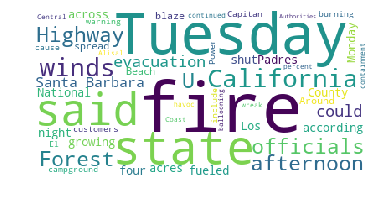

In [19]:
exclude = set(stopwords.words('english'))
wordcloud = WordCloud(background_color = 'white', stopwords = exclude, max_words = 50).generate(text)
plt.imshow(wordcloud)
plt.axis("off")
plt.show();